In [1]:
from wholeslidedata.iterators import create_batch_iterator
from matplotlib import pyplot as plt
from utils import init_plot, plot_batch, show_plot, print_dataset_statistics
from shapely.prepared import prep
import os
import numpy as np
from pprint import pprint
import yaml
from wholeslidedata.annotation import utils as annotation_utils
from label_utils import to_dysplastic_vs_non_dysplastic
import random
import matplotlib.patches as mpatches

In [2]:
# open config for plotting
user_config = './configs/plot_config.yml'
batches = 2 
repeats = 1
cpus = 1
mode = 'training'

# lets print some configs
with open(user_config, 'r') as yamlfile:
    data = yaml.load(yamlfile, Loader=yaml.FullLoader)
    
for k, v in data['wholeslidedata']['default'].items():
    print('{}: {}'.format(k, v))

yaml_source: data.yml
seed: 2
label_map: {'ndbe-g': 1, 'lgd-g': 2, 'hgd-g': 3}
annotation_sources: {'filters': ['xml']}
batch_shape: {'batch_size': 4, 'spacing': 1, 'shape': [512, 512, 3]}
label_sampler: {'attribute': 'OrderedLabelSampler'}
annotation_sampler: {'attribute': 'OrderedAnnotationSampler'}
point_sampler: {'attribute': 'UniformPointSampler'}


In [3]:
# create a batch iterator for plotting
training_batch_generator =  create_batch_iterator(user_config=user_config, 
                                                    number_of_batches=batches, 
                                                    mode='training',  
                                                    cpus=cpus)
    
# print dataset statistics
dataset = training_batch_generator.dataset
print('Training dataset:')
print_dataset_statistics(dataset)

Training dataset:
Annotation level: {'hgd-g': 604, 'lgd-g': 271, 'ndbe-g': 1744}
Pixel level: {'hgd-g': 228433449, 'lgd-g': 93886284, 'ndbe-g': 460527040}
Pixel percentage per class: {'hgd-g': 29.18, 'lgd-g': 11.99, 'ndbe-g': 58.83}


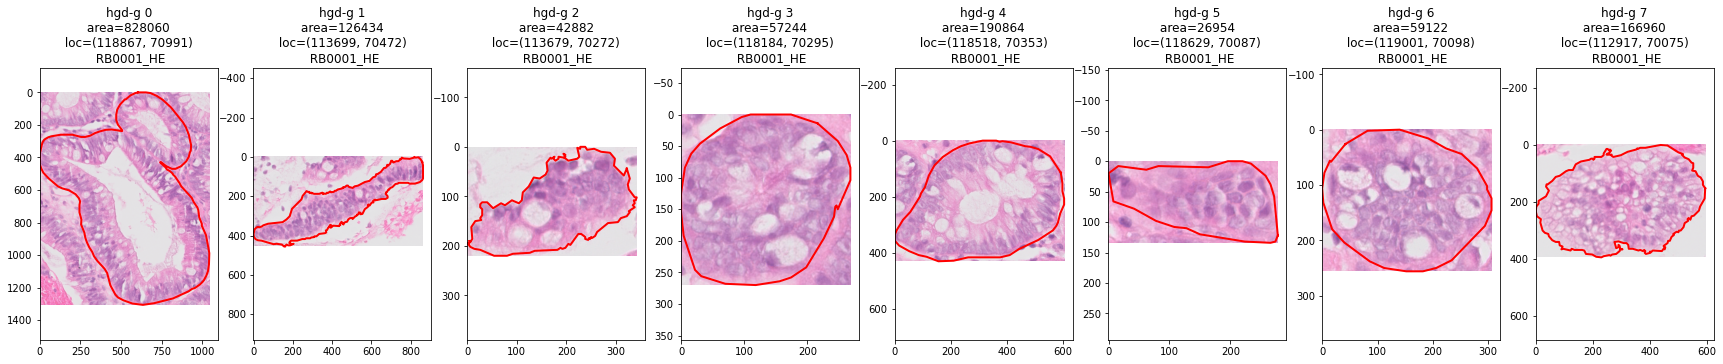

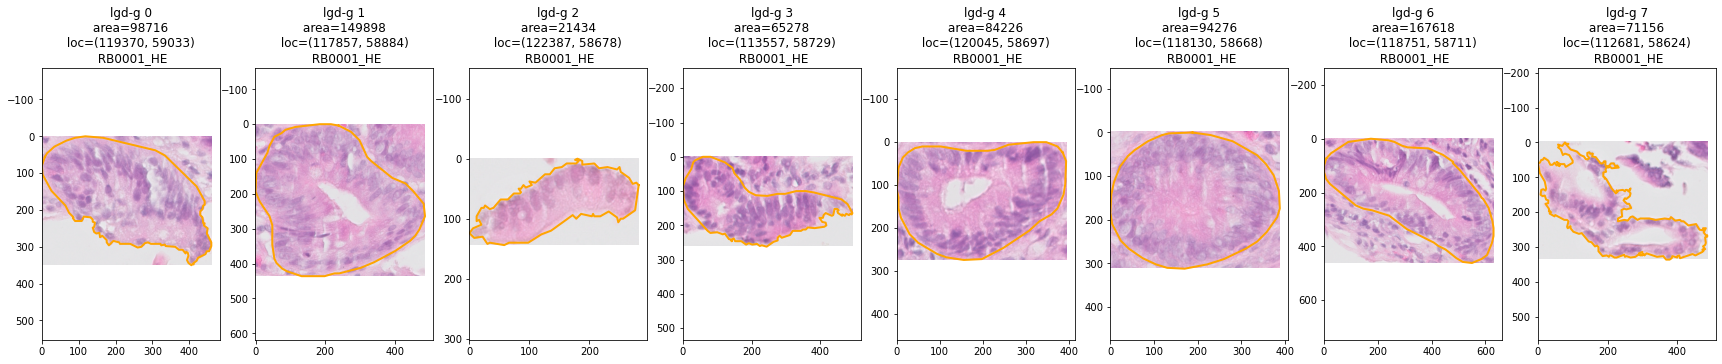

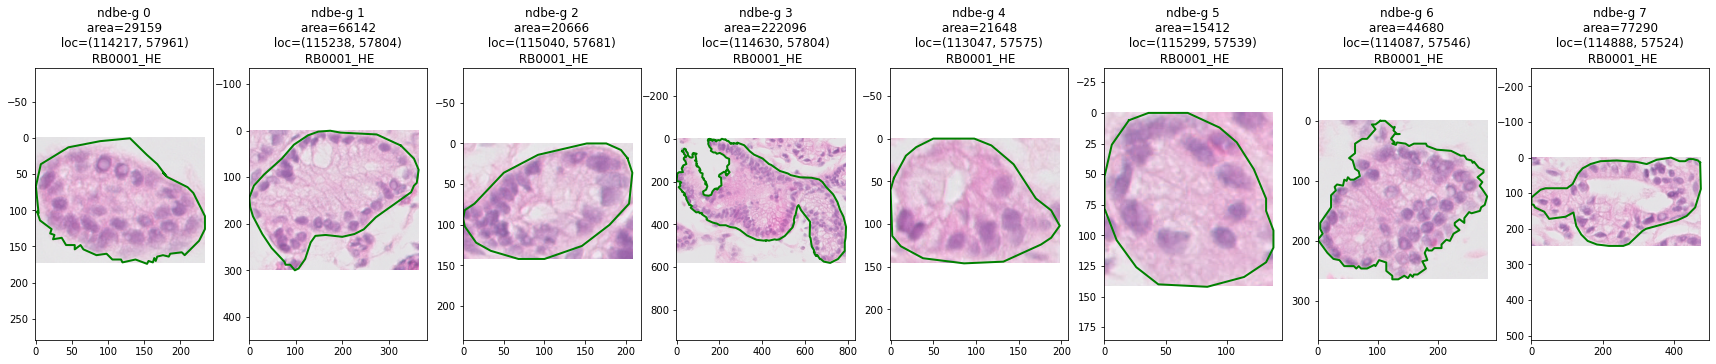

In [4]:
# show annotations
color_map = {'e-stroma': "blue", 'ndbe-g': "green", 'lgd-g': "orange", 'hgd-g': "red", 'squamous-t': 'pink'}

for label in dataset.sample_references.keys():
    
    # random examples 
    #references = random.sample(dataset.sample_references[label], 8)
    references = dataset.sample_references[label][:8]

    fig, ax = plt.subplots(1, len(references), figsize=(30,5))
    for idx, reference in enumerate(references):

        # get the associated image
        image = dataset.get_wsi_from_reference(reference)

        # get the polygon from the associated annotations
        wsa = dataset.get_wsa_from_reference(reference)
        annotation = wsa.annotations[reference.annotation_index]

        # note the spacing 0.25 (magnification level = 40)
        patch = image.get_annotation(annotation, 0.25)
        ax[idx].imshow(patch)
        title = f'{label} {idx}\n area={int(annotation.area)} \n loc={annotation.center} \n {reference.file_key}'
        annotation_utils.plot_annotations([annotation], title=title, ax=ax[idx], use_base_coordinates=True, color_map=color_map)
    plt.show()

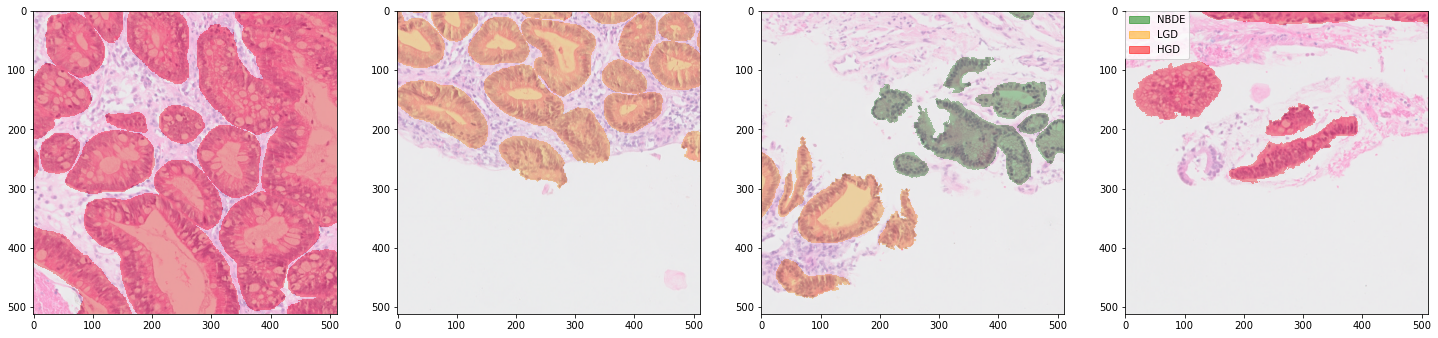

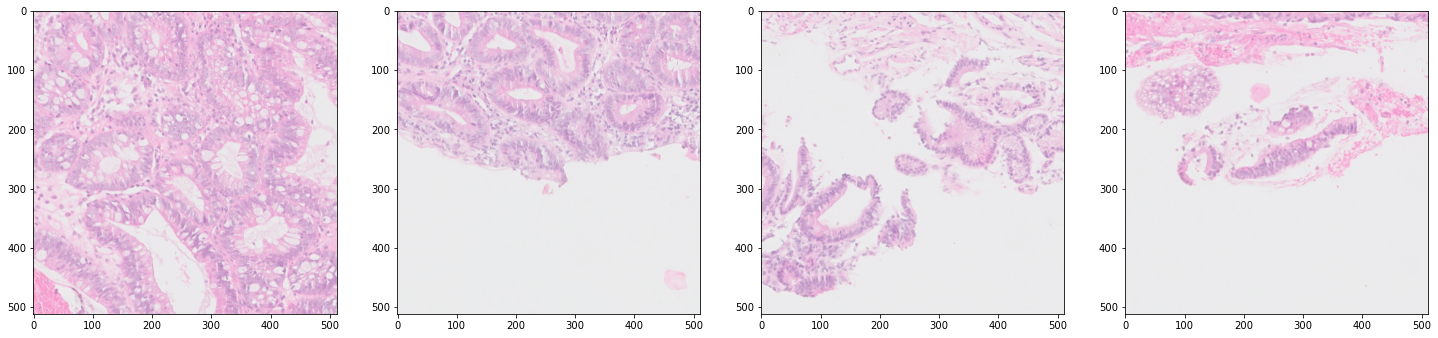

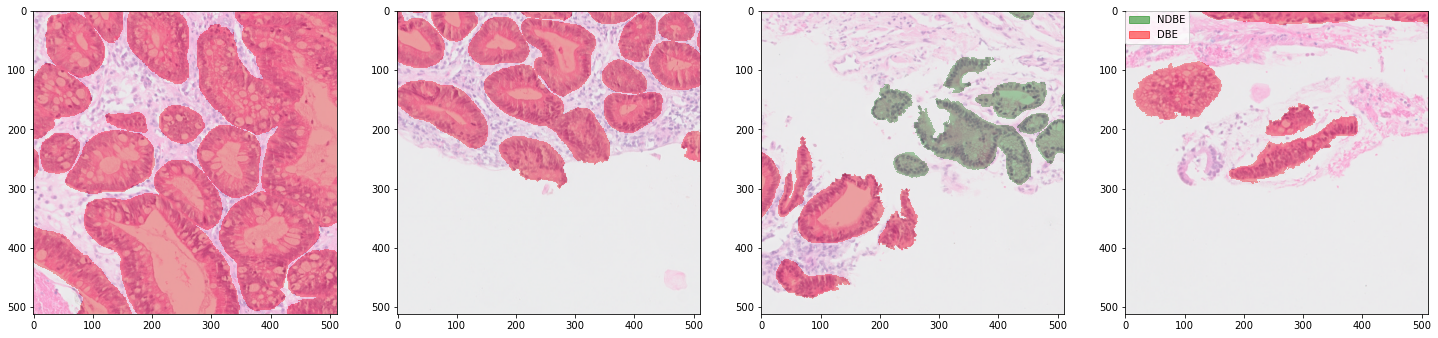

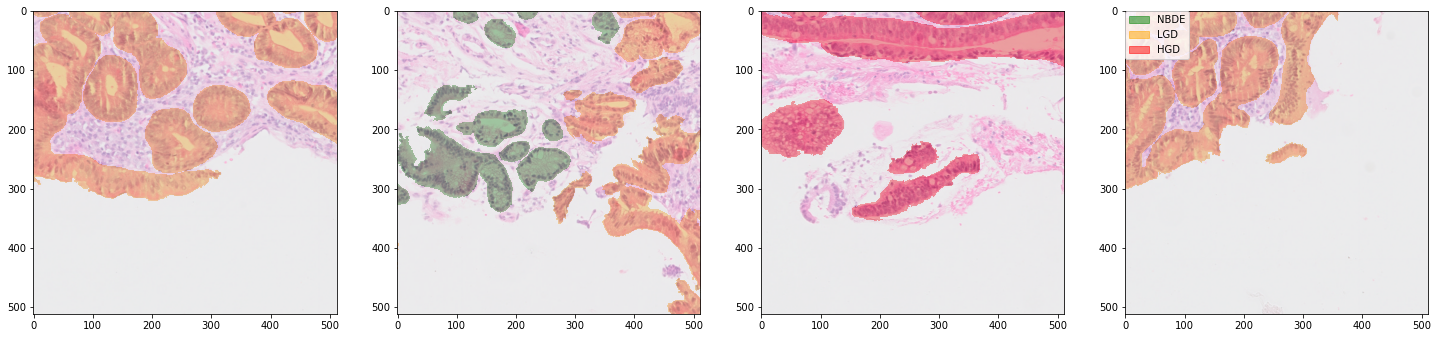

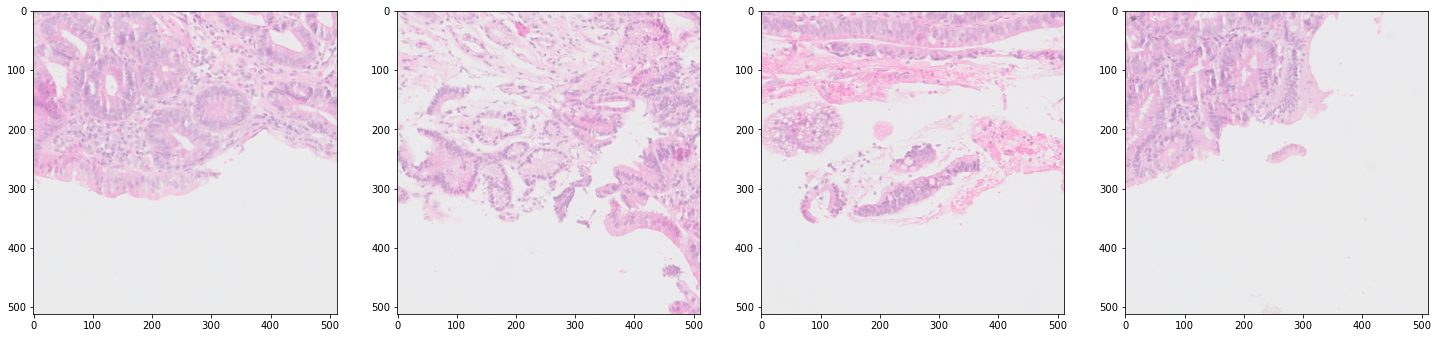

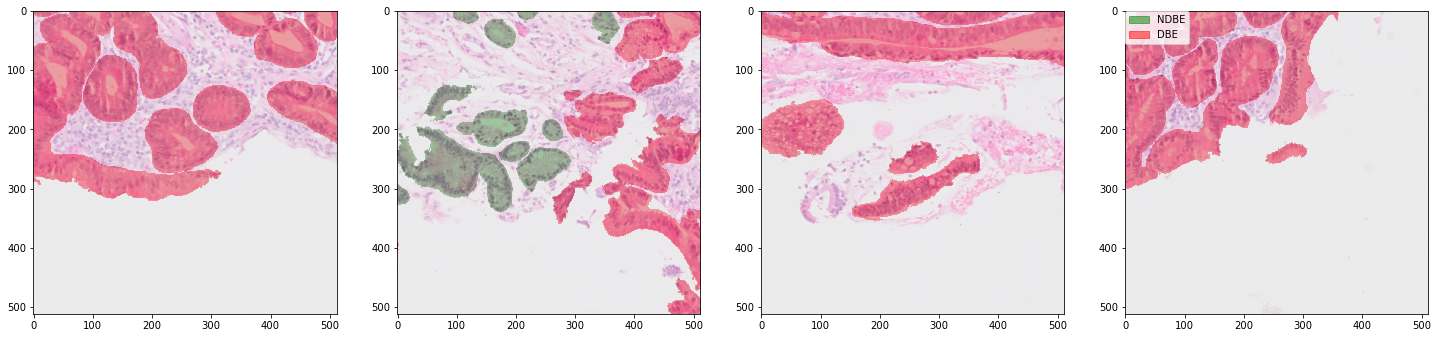

In [5]:
# show some patches
colors_1 = ["white", "green", "orange", "red", 'yellow', 'yellow', 'purple', 'pink', 'grey', "blue"]
colors_2 = ["white", "green", "red", "yellow", 'brown', 'yellow', 'purple', 'pink', 'grey', 'green']

for r in range(repeats):
    for idx, (x, y, info) in enumerate(training_batch_generator):
        
        # how many patches to plot
        patches = 4

        # ndbe, lgd, hgd
        fig, axes = plt.subplots(1, patches, figsize=(25, 6), squeeze=False)
        plot_batch(axes, 0, x[:patches], y[:patches], alpha=0.3, colors=colors_1)
        green_patch = mpatches.Patch(color='green', label='NBDE', alpha=0.5)
        orange_patch = mpatches.Patch(color='orange', label='LGD', alpha=0.5)
        red_patch = mpatches.Patch(color='red', label='HGD', alpha=0.5)
        plt.legend(handles=[green_patch, orange_patch, red_patch],
                         loc='upper left', borderaxespad=0.)
        plt.show()
        
        # show just the image
        y_zeros = np.zeros_like(y)
        fig, axes = plt.subplots(1, patches, figsize=(25, 6), squeeze=False)
        plot_batch(axes, 0, x[:patches], y_zeros[:patches], alpha=0.3, colors=colors_2)
        plt.show()

        # ndbe vs dbe
        y = to_dysplastic_vs_non_dysplastic(y)
        fig, axes = plt.subplots(1, patches, figsize=(25, 6), squeeze=False)
        plot_batch(axes, 0, x[:patches], y[:patches], alpha=0.3, colors=colors_2)
        green_patch = mpatches.Patch(color='green', label='NDBE', alpha=0.5)
        red_patch = mpatches.Patch(color='red', label='DBE', alpha=0.5)
        plt.legend(handles=[green_patch, red_patch],
                         loc='upper left', borderaxespad=0.)
        plt.show()
        print('\n')